## Stock market prediction based on patent novelty - Vector of words based novelty measures

Here we make the predictions using the within sector novelty measures based on vector of words. We take the same preprocessing steps as in notebook 3_1.

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv("../data/all_novelty_within_sector.csv")
df = df.drop(columns=['lda_avg_similarity_5','lda_avg_similarity_10', 'lda_avg_similarity_20']) #drop topic-based similarity measures
stock_prices = pd.read_csv("../data/stockprices_2000_2020.csv")
print(df.shape)
print(stock_prices.shape)

(427, 15)
(369810, 3)


In [14]:
df.ticker.value_counts()

CL     335
CHD     70
HSY     18
CPB      4
Name: ticker, dtype: int64

In [15]:
stock_prices = stock_prices[(stock_prices["Ticker"]=="CL") | 
                            (stock_prices["Ticker"]=="CHD") |
                            (stock_prices["Ticker"]=="HSY") |
                            (stock_prices["Ticker"]=="CPB")]
stock_prices.shape

(21132, 3)

In [16]:
# Keeping range of dates for which we have patent data

stock_prices["date"] = pd.to_datetime(stock_prices["Date"])
df["date"] = pd.to_datetime(df["issue_date"])
stock_prices = stock_prices[(stock_prices["date"]>=df.date.min()) &
                            (stock_prices["date"]<=df.date.max())]
stock_prices = stock_prices.drop(columns=["Date"])

stock_prices = stock_prices.rename(columns={'Ticker': 'ticker'})

In [17]:
stock_prices.head()

,ticker,Adj Close,date
145157,CHD,-0.013531,2010-01-05
145158,CHD,0.004792,2010-01-06
145159,CHD,-0.011184,2010-01-07
145160,CHD,-0.002162,2010-01-08
145161,CHD,-0.004334,2010-01-11


In [18]:
# Many patents are published on the same date - we take average and max 

df_reduc = df.drop(columns=["text", "patent_id", "clean_corpus", "issue_date"])
df2_avg = df_reduc.groupby(['ticker', 'date', 'sector']).mean().reset_index()
df2_max = df_reduc.groupby(['ticker', 'date', 'sector']).max().reset_index()


In [19]:
df_reduc.columns

Index(['ticker', 'numpat_total', 'sector', 'bow_avg_similarity_5',
       'bow_avg_similarity_10', 'bow_avg_similarity_20', 'nw', 'nb', 'nt',
       'nwc', 'nov', 'date'],
      dtype='object')

In [20]:
# Columns to exclude from renaming
exclude_cols = ['ticker', 'date', 'sector', 'numpat_total', 'nw', 'nb', 'nt', 'nwc', 'nov']
# Mapping dictionary for renaming max cols
rename_dict_max = {col: col + '_max' for col in df2_max.columns if col not in exclude_cols}
# Mapping dictionary for renaming avg cols
rename_dict_avg = {col: col + '_avg' for col in df2_avg.columns if col not in exclude_cols}

# Rename the columns
df2_max.rename(columns=rename_dict_max, inplace=True)
df2_avg.rename(columns=rename_dict_avg, inplace=True)
df2_max = df2_max.drop(columns=['nw', 'nb', 'nt', 'nwc','nov'])

In [21]:
# Merging the two datasets
merged = pd.merge(stock_prices, df2_avg, on=["date", "ticker"], how="left")
merged = pd.merge(merged, df2_max, on=["date", "ticker", "sector", "numpat_total"], how="left")
merged.shape

(8928, 16)

We end up with a dataset with a lot of NA values, since we have data for 8928 days/tickers, but new patents were only released in 256 cases.

In [23]:
merged.to_csv("../data/stockprices_novelty_merged_sector_bow.csv")

## Preprocessing and modelling

We only take at this point a few preprocessing steps: dropping the variable for sector (as we are only working with one), getting the total number of patents for each company, filling NAs with 0 for the novelty measures (0 signalling no innovation), and transforming the column 'date' into date format.

It is worth noting that in previous version of this exercise, we included other features (such as lags and rolling means of the novelty measures), but they did not add value to the predictions, so here we keep the simpler version.

We set the start of the test set in 2017.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("../data/stockprices_novelty_merged_sector_bow.csv").drop(columns=["Unnamed: 0"])

# Sector does not give us extra information

df = df.drop(columns=["sector"])

# Calculate the maximum value within each group
numpatents = df.groupby('ticker')['numpat_total'].transform('max')

# Assign the maximum values to a new column 'max_value'
df['numpat_total'] = numpatents

test_time_start = '2017'

df = df.fillna(0) # Filling NAs with 0 (signaling "no innovation")

df["date"] = pd.to_datetime(df["date"])

df.sort_values(['ticker', 'date'], inplace=True)


### Benchmark

+ Naive model

We started by building a naive prediction model that forecasts the future values of the target variable using the last known value for each observation. This approach assumes that the future values of the target variable will be similar to the previous observed values, making it a simple baseline model for comparison with more sophisticated prediction techniques.

In [3]:
test_time_start = '2017-01-01'
train = df.loc[df.date < test_time_start]
test = df.loc[df.date >= test_time_start]

companies = df['ticker'].unique()

def apply_naive_prediction(train, test, target, companies):
    y_pred = []  # Initialize y_pred as an empty list
    for c in companies:
        train_c = train[train["ticker"]==c]
        test_c = test[test["ticker"]==c]

        y_pred_1 = train_c[target].iloc[-1]
        y_pred_2 = test_c[target].shift(1)  # Shift the values by 1 timestep
        y_pred_c = y_pred_2.fillna(y_pred_1)
        y_pred.append(y_pred_c)  # Append the predicted values to y_pred list

    return pd.concat(y_pred)  # Concatenate the predicted values into a single series or dataframe


y_pred = apply_naive_prediction(train, test, "Adj Close", companies)

mse_naive = mean_squared_error(test["Adj Close"], y_pred, squared=False)
print("Mean Squared Error:", mse_naive)


Mean Squared Error: 0.01842054595810413


### Model 1
Our first model for generating prediction is a machine learning approach, particularly random forest model. We consider:

+ Fixed effects by company (ticker dummies).
+ Include past information for stock market variation (rolling means for 3, 6, 15, 30, 60, 120 days)
+ Model: RF + hyperparameter tunning
+ 2 versions: with and without novelty data - now generated via the BoW methodology instead of LDA-.

In [29]:
# Shifting target by 1 day

# Function for defining Y variable

def make_target(df, t):
    '''t is the number of periods to shift forward'''
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(by=['ticker', 'date'])

    # loop through each period and generate the shift variables
    for i in range(1, t+1):
        col_name = f'Adj Close{i}'
        df[col_name] = df.groupby(['ticker'])['Adj Close'].shift(-i)

    # take the maximum for t periods forward and create the new variable
    df['target_f{}'.format(t)] = df[[f'Adj Close{i}' for i in range(1, t+1)]].max(axis=1, skipna=False)

    # drop the shift variables
    df = df.drop(columns=[f'Adj Close{i}' for i in range(1, t+1)])

    return(df)

In [30]:
df_target = make_target(df, 1)
df_target.tail()

,ticker,Adj Close,date,numpat_total,bow_avg_similarity_5_avg,bow_avg_similarity_10_avg,bow_avg_similarity_20_avg,nw,nb,nt,nwc,nov,bow_avg_similarity_5_max,bow_avg_similarity_10_max,bow_avg_similarity_20_max,target_f1
8923,HSY,0.003343,2018-11-07,27.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.009070
8924,HSY,-0.009070,2018-11-08,27.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.014103
8925,HSY,0.014103,2018-11-09,27.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000829
8926,HSY,0.000829,2018-11-12,27.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.004325
8927,HSY,0.004325,2018-11-13,27.0,0.124452,0.121791,0.112346,0.0,0.0,0.0,0.0,0.0,0.124452,0.121791,0.112346,NaN


In [31]:
# Here we generate variables for the past 3 to 120 days with a rolling mean of Adj Close
df_target["date"] = pd.to_datetime(df_target["date"])
panel_data= df_target.copy()
panel_data = panel_data.sort_values(by=['ticker', 'date'])
lcols = (panel_data.groupby(['ticker'])['Adj Close'] 
         .transform(lambda x: x.rolling(w, min_periods=1).mean()) # rolling mean
         .rename('past' + str(w-1)) 
         for w in [4, 7, 16, 31, 61, 121])
panel_data = panel_data.join(pd.DataFrame(lcols).transpose())

In [32]:
# OHE for ticker

dummies = pd.get_dummies(panel_data['ticker'], dtype=int)
merged = pd.concat([panel_data, dummies], axis=1)

merged = merged.drop(columns=["ticker", "Adj Close"])

+ Model including novelty measures

In [33]:
# Split the data into training and test 
train = merged.loc[merged.date < test_time_start]
test = merged.loc[merged.date >= test_time_start]
test = test.dropna()

X_train = train.drop('target_f1', axis=1).drop(columns=["date"])  # Features
y_train = train['target_f1']  # Target variable
X_test = test.drop('target_f1', axis=1).drop(columns=["date"])  # Features
y_test = test['target_f1']  # Target variable

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training features
scaler.fit(X_train)

# Apply the scaler to both the training and test features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#Model with novelty measures

param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 5, 7, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 20]
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.00017090176822586977


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center')
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

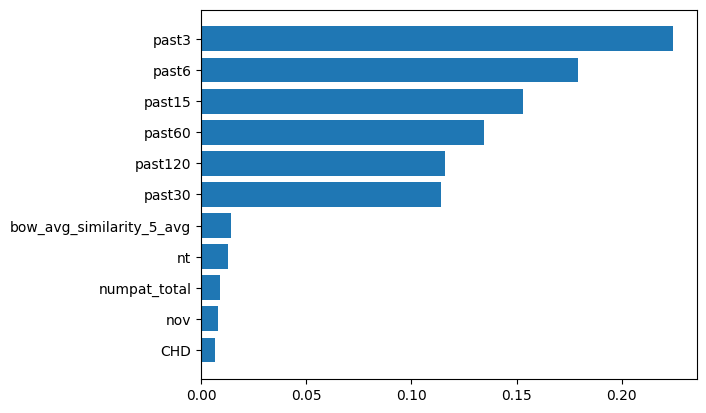

[18, 8, 0, 6, 1, 15, 17, 16, 14, 13, 12]

In [43]:
feature_names = X_train.columns

feature_imp(abs(best_model.feature_importances_), feature_names)

From this plot we can interpret that the features with the highest importance are the variables related to the past 3, past 6, past 15, past 60, past 120 and past 30 stock market prices. These are the variables that are more significant to the model's prediction power. The novelty measures do not seem to be the most important features.

+ Model excluding novelty measures

In [ ]:
#Exclude novelty measures
novel_vars = ['bow_avg_similarity_5_avg', 'bow_avg_similarity_10_avg',
       'bow_avg_similarity_20_avg', 'nw', 'nb', 'nt', 'nwc', 'nov',
       'bow_avg_similarity_5_max', 'bow_avg_similarity_10_max',
       'bow_avg_similarity_20_max']

X_train_no_novel = X_train.drop(columns=novel_vars)
X_test_no_novel = X_test.drop(columns=novel_vars)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training features
scaler.fit(X_train_no_novel)

# Apply the scaler to both the training and test features
X_train_no_novel_scaled = scaler.transform(X_train_no_novel)
X_test_no_novel_scaled = scaler.transform(X_test_no_novel)

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#Model without novelty measures

param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 5, 7, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 20]
}

rf_model = RandomForestRegressor(random_state=42)

grid_search_no_novel = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_no_novel.fit(X_train_no_novel_scaled, y_train)

best_model_no_novel = grid_search_no_novel.best_estimator_

y_pred_no_novel = best_model_no_novel.predict(X_test_no_novel_scaled)
mse_no_novel = mean_squared_error(y_test, y_pred_no_novel)
print("Mean Squared Error:", mse_no_novel)

Mean Squared Error: 0.0001709835569661605


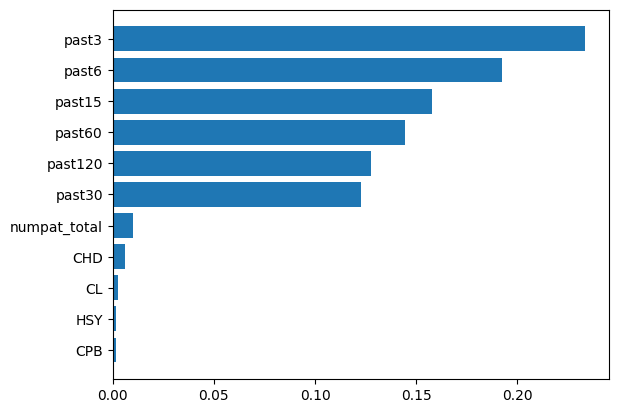

[9, 10, 8, 7, 0, 4, 6, 5, 3, 2, 1]

In [45]:
feature_names = X_train_no_novel.columns

feature_imp(abs(best_model_no_novel.feature_importances_), feature_names)

As in the previous model, the features with the highest importance are the variables related to the past 3, past 6, past 15, past 60, past 120 and past 30 stock market prices (rolling means). The MSE is very similar in this model as in the model that includes novelty measures. Similarly as in the LDA case, here novelty measures do not seem to add accuracy to the predictions.

### Model 2

+ ARIMA - pooled approach

As a second model we incorporated an ARIMA model, since it is a popular time series forecasting model that incorporates autoregressive, moving average, and differencing components.

For the homework, we generated four models, one per ticker. Here, we opt for a pooled approach that gives us insights about forecasting at the sector level.

Similarly as before, we generate two models: including and excluding novelty measures.

In [4]:
# !pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA

In [5]:
df_timeseries = df.copy()

df_timeseries["date"] = pd.to_datetime(df_timeseries["date"])

# Set the 'date' column as the index
df_timeseries.set_index('date', inplace=True)

# Create dummy variables for each company
company_dummies = pd.get_dummies(df_timeseries['ticker'], prefix='company', dtype=int)

# Concatenate the original data with the company dummies
df_timeseries = pd.concat([df_timeseries, company_dummies], axis=1)

df_timeseries = df_timeseries.drop(columns=["ticker"])
df_timeseries.head()

,Adj Close,numpat_total,bow_avg_similarity_5_avg,bow_avg_similarity_10_avg,bow_avg_similarity_20_avg,nw,nb,nt,nwc,nov,bow_avg_similarity_5_max,bow_avg_similarity_10_max,bow_avg_similarity_20_max,company_CHD,company_CL,company_CPB,company_HSY
date,,,,,,,,,,,,,,,,,
2010-01-05,-0.013531,395.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2010-01-06,0.004792,395.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2010-01-07,-0.011184,395.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2010-01-08,-0.002162,395.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2010-01-11,-0.004334,395.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0


+ Model without exogenous variables (excluding novelty measures)

In [6]:
import warnings
warnings.filterwarnings("ignore")

# Specify the order of the ARIMA model (p, d, q)
p = 1  # AR order
d = 1  # Differencing order
q = 1  # MA order

# Separate the target variable (stock values) and covariates from the combined dataset
y = df_timeseries['Adj Close']
X = df_timeseries.drop(columns=["Adj Close"])

# Split the data into train and test based on date
test_start_date = pd.to_datetime('2017-01-01')
X_train = X[X.index < test_start_date]
X_test = X[X.index >= test_start_date]
y_train = y[y.index < test_start_date]
y_test = y[y.index >= test_start_date]

# Standardize the covariates using a scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to a DataFrame with original column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Fit the pooled ARIMA model with exogenous variables
model = ARIMA(y_train, order=(p, d, q))
model_fit_simple = model.fit()

print("Pooled Model: no covariates")
print(model_fit_simple.summary())

# Make predictions on the test set with exogenous variables
y_pred_arima_simple = model_fit_simple.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# Calculate the mean squared error (MSE) on the test set
mse_arima_simple = mean_squared_error(y_test, y_pred_arima_simple, squared=False)
print(f"Mean Squared Error: {mse_arima_simple}")


Pooled Model: no covariates
                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 7044
Model:                 ARIMA(1, 1, 1)   Log Likelihood               21888.717
Date:                Mon, 26 Jun 2023   AIC                         -43771.433
Time:                        11:39:39   BIC                         -43750.854
Sample:                             0   HQIC                        -43764.344
                               - 7044                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0559      0.010     -5.341      0.000      -0.076      -0.035
ma.L1         -0.9999      0.019    -51.511      0.000      -1.038      -0.962
sigma2         0.0001   

+ Model with exogenous variables (including novelty measures)

In [7]:
# Fit the pooled ARIMA model with exogenous variables
model = ARIMA(y_train, order=(p, d, q), exog=X_train_scaled)
model_fit = model.fit()

print("Pooled Model")
print(model_fit.summary())

# Make predictions on the test set with exogenous variables
y_pred_arima = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

# Calculate the mean squared error (MSE) on the test set
mse_arima = mean_squared_error(y_test, y_pred_arima, squared=False)
print(f"Mean Squared Error: {mse_arima}")

Pooled Model
                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 7044
Model:                 ARIMA(1, 1, 1)   Log Likelihood               21384.153
Date:                Mon, 26 Jun 2023   AIC                         -42730.307
Time:                        11:39:56   BIC                         -42599.971
Sample:                             0   HQIC                        -42685.409
                               - 7044                                         
Covariance Type:                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
numpat_total                  0.0045      0.001      4.966      0.000       0.003       0.006
bow_avg_similarity_5_avg      0.0008      0.002      0.353      0.724    

Based on the MSE of both ARIMA models, one including exogenous variables and one without, it can be concluded that the ARIMA model **without** additional features performs better than the one that includes the additional features, such as novelty measures and past data. In the same line, we see that the novelty measures added in the second model are not significant at a 95% confidence level.

## Summary

In [8]:
sum = {'Model': ['Naive','Random Forest', 'Random Forest (including novelty measures)', 'ARIMA', 'ARIMA (including novelty measures)'],
    'MSE (LDA)': [0.01842,0.00017,0.00017,0.01302,0.04136],
    'MSE (BOW)': [0.01842,0.00017,0.00017,0.01302,0.03727]}

results = pd.DataFrame(sum)

results

,Model,MSE (LDA),MSE (BOW)
0,Naive,0.01842,0.01842
1,Random Forest,0.00017,0.00017
2,Random Forest (including novelty measures),0.00017,0.00017
3,ARIMA,0.01302,0.01302
4,ARIMA (including novelty measures),0.04136,0.03727


Based on the MSE of each model, we can conclude that the Random Forest model performs better in both cases, whether using topic-based or word-based similarity measures. However, it is interesting to note that the Random Forest model's MSE is almost the same when including or excluding those novelty measures. This suggests that the novelty measures do not significantly contribute additional information for forecasting stock prices in this particular sector when considering within-sector novelty measures.